In [1]:
import os
from pypdf import PdfReader
from readability import Readability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [25]:
joined = pd.read_excel('excel tables/Scraped Data.xlsx')
joined = joined.rename(columns={"title": "Book Name", 'category':'Category', 'url':'URL', 
                                    'illustrators': 'Illustrators Scraped', 'ages':'Age',
                                    'book parametes': 'Book Parametes', 'sold to': 'Sold To', 
                                    'description': 'Description', 'writers': 'Authors Scraped'})
joined.to_excel('excel tables/Scraped Data.xlsx')

#### Sold licences

Gunning fog index - dependent on 'difficult' words (3+ syllables)
Flesch–Kincaid - dependent on total words, syllables and sentences

In [18]:
column = 'Difficult words'
readability_scores = pd.read_excel('excel tables/Readability scores plain.xlsx')
pages = pd.read_excel('excel tables/Readability scores.xlsx', usecols = ['Book Name', 'Pages'])
df = pd.merge(readability_scores, pages, how='inner',  on="Book Name")
joined = pd.read_excel('excel tables/Scraped Data.xlsx')
df = pd.merge(df, joined, how = 'inner', on="Book Name")
df.dropna(subset=['Age', column], inplace=True)
df.Age = df.Age.apply(lambda x: int(x.split('-')[0]) if '-' in x else int(x.strip('+')) ) 
df.to_excel('excel tables/Scraped and Readability.xlsx')

#### Compute correlation between readability and age 
link: https://www.geeksforgeeks.org/spearmans-rank-correlation/ https://stats.stackexchange.com/questions/172545/correlation-between-continuous-data-and-count-data

#### Number ot difficult words per tokens/pages
difficult words - more than 3 syllables

Spearman's correlation coefficient: 0.7711434249873761
p-value: 2.055305240136525e-31


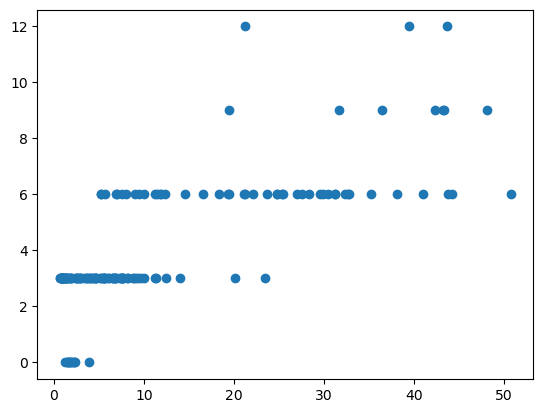

In [19]:
x = [x/y for x,y in zip(df[column], df['Pages'])] 
y = df['Age']
# calculate Spearman's correlation coefficient and p-value
corr, pval = spearmanr(x, y)
 
# print the result
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

plt.scatter(x, y)
plt.show()

Spearman's correlation coefficient: -0.6355654714433643
p-value: 1.0931542218389848e-18


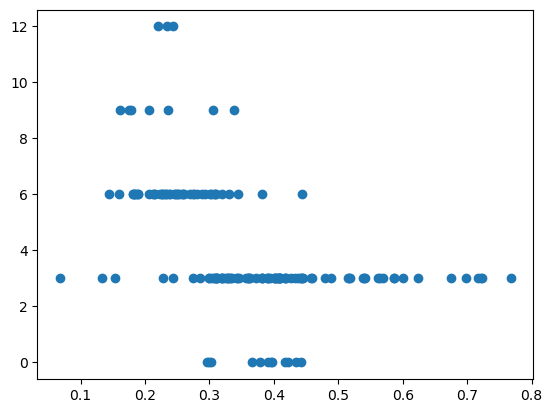

In [20]:
x = df['Type-Token'] 
y = df['Age']
# calculate Spearman's correlation coefficient and p-value
corr, pval = spearmanr(x, y)
 
# print the result
print("Spearman's correlation coefficient:", corr)
print("p-value:", pval)

plt.scatter(x, y)
plt.show()

In [36]:
df['Difficult words-Page ratio'] = x
X = df[['Difficult words-Page ratio', 'Type-Token', 'Readability Gunning Fog score', 'Readability Flesch score', 'Pages', 'Tokens']]

### SVM

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM model
svm_model = SVC(kernel='linear') 
svm_model.fit(X_train, y_train)

# Predictions
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# Error metrics
train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

print(f"Train Error: {train_error:.2f}")
print(f"Test Error: {test_error:.2f}")


Train Error: 0.15
Test Error: 0.26


#### Plot

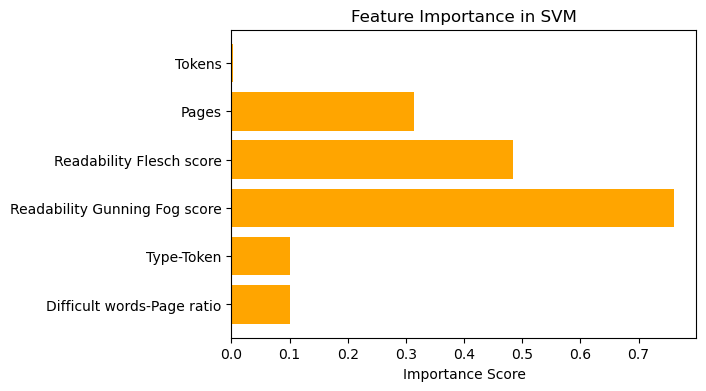

In [38]:
# Plot
feature_names = X.columns

# Get absolute values of coefficients
feature_importance_svm = np.abs(svm_model.coef_).mean(axis=0)

# Plot feature importance for SVM
plt.figure(figsize=(6, 4))
plt.barh(feature_names, feature_importance_svm, color='orange')
plt.xlabel("Importance Score")
plt.title("Feature Importance in SVM")
plt.show()

### Random forrest

Train Error: 0.00
Test Error: 0.21


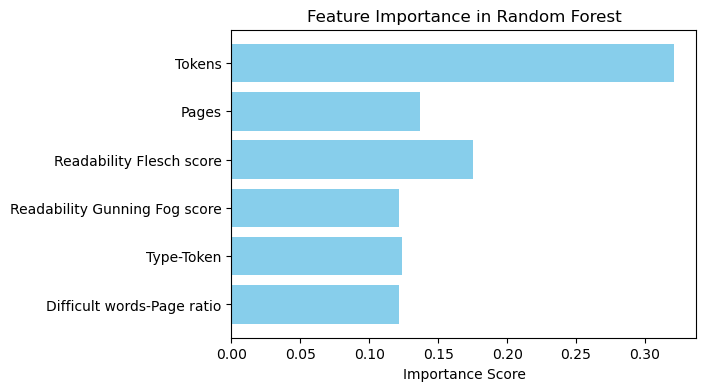

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Error metrics
train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

# Plot
feature_names = X.columns

# Get feature importances
importances = rf_model.feature_importances_

print(f"Train Error: {train_error:.2f}")
print(f"Test Error: {test_error:.2f}")

# Plot feature importance
plt.figure(figsize=(6, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance Score")
plt.title("Feature Importance in Random Forest")
plt.show()

## WITHOUT AGE

#### Sold licences

In [ ]:
licences = pd.read_excel('excel tables/podklady Albatros CRM.xlsx', sheet_name='prodane licence')
licences = licences.drop(columns = ['Valid from Date', 'Valid till Date', 'License: License Code'])
licences =licences.drop_duplicates()
licences = licences.groupby(['Book'], as_index=False).agg({
    'Languages': list, 
    'Account: Account Name': list,  
    'Territory': list
})
licences = licences.rename(columns={"Book": "Book Name"})

In [ ]:
column = 'Difficult words'
readability_scores = pd.read_excel('excel tables/Readability scores plain.xlsx')
pages = pd.read_excel('excel tables/Readability scores.xlsx', usecols = ['Book Name', 'Pages'])
df = pd.merge(readability_scores, pages, how='inner',  on="Book Name")
df = pd.merge(df, licences, how = 'inner', on="Book Name")
df = pd.merge(df, joined, how = 'inner', on="Book Name")